# Sentiment Analysis

---

Business Problem: You are working at Foods Inc as a data analyst. The company is a chain of sophisticated restaurants in Brazil and is expanding rapidly, also operating in the Uruguay and Paraguay segments.
The company is currently in the process of modernizing technologies and processes, the company's main focus now is to target customers and products, one of the company's biggest updates is the creation of an online application that works like an "online restaurant", the customer Create an account on the app and order food, after that the restaurant creates food and sends it to the customer's home.
A very simple e-commerce, but for food.
By creating an account, customers can order any type of food available from restaurants near their location. After that, the restaurant creates the order and delivery the food to the customer location, the customer can provide post delivery feedback and a star rating.
This application has been running for a year and the company has collected some raw data and now its challenge is to provide insights with this data set.
One of the main objectives is to create an estimator that works as a validator of sentiment scores.
If the score is 5 and the text is "very bad", you will need to confirm this score with an estimator.

In this small project I aim to train my skills with Spark on multiclass classification problems.

The project basically consists of sentiment analysis pipeline using kaggle dataset product reviews on this link: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews.

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

Dataset Overview:

- *Id*: Row Number.
- *ProductId*: Product that customer buy at a restaurant.
- *UserId*: Customer indentification.
- *ProfileName*: Customer Profile.
- *Time*: Feedback timestamp.
- *HelpfulnessNumerator|HelpfulnessDenominator*: Indicators.
- *Score*: Sentiment.
- *Summary*: A summary of text.
- *Text*: Customer feedback.

## 0.0. Requirements

### 0.1. Imports

In [18]:
#import mlflow
import numpy as np
import pandas as pd
from time import time

import torch
import torch.nn.functional as F

import seaborn as sns 
from matplotlib import pyplot as plt

from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql.types import (
    FloatType,
    ArrayType,
    DoubleType,
    IntegerType,
    StructField,
    StructType
)

from pyspark.sql import functions as pf
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.utils import AnalysisException

from pyspark.ml import Pipeline
from pyspark.ml import Transformer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.functions import array_to_vector, predict_batch_udf

from transformers import AutoTokenizer, AutoModel

### 0.2. Aux Functions

In [2]:
spark = SparkSession.builder \
        .master("local[*]") \
        .config("spark.driver.memory", "10g") \
        .config("spark.executor.memory", "10g") \
        .getOrCreate()

sc = spark.sparkContext

sc

24/06/07 12:01:32 WARN Utils: Your hostname, grc resolves to a loopback address: 127.0.1.1; using 192.168.3.7 instead (on interface eno1)
24/06/07 12:01:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/07 12:01:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
class NoiseLableRemoval(Transformer):
    """
    This class is responsible for filtering wrong Scores
    and for create label class associated with the scores.

    inputs:
        - inputCol: Column that will be transformed.
        - outputCol: Output Column name.
        - labelCol: Label / Score column to generate Bad, Neutral or Good label.

    returns:
        - df: Transformed DataFrame. 

    """

    def __init__(
        self,
        inputCol: str = "Text",
        outputCol: str = "Text",
        labelCol: str = "Score"
    ):

        self.inputCol = inputCol
        self.outputCol = outputCol
        self.labelCol = labelCol

    # Transform
    def _transform(self, dataset: DataFrame) -> DataFrame:
        y_col = self.labelCol
        
        if y_col not in dataset.columns:
            raise AnalysisException(f"'{y_col}' column not exists on DataFrame")

        # check consistent labels
        current_labels = [j[0] for j in dataset.select(pf.col(y_col)).distinct().collect()]
        current_labels.sort()

        if current_labels == [0, 1, 2]:
            return dataset

        else:
            df = dataset.filter(pf.col(y_col).isin([0, 1, 2, 3, 4, 5]))

            # Good, Neutral and Bad
            df = df.withColumn(
                y_col,
                pf.when(pf.col(y_col) < 2, 0) \
                .when((pf.col(y_col) >= 2) & (pf.col(y_col) < 4), 1) \
                .when(pf.col(y_col) >= 4, 2)
            )

            return df
    
class FilterRowsFeatures(Transformer):
    """
    This class is responsible for filtering rows and columns in dataset.

    inputs:
        - aggCols: Columns to Agg and Keep.
        - keyCol: Column to be unique key.

    returns:
        - df: Transformed DataFrame. 

    """

    def __init__(
        self,
        aggCols: list,
        keyCol: str = "Id"
    ):
        self.aggCols = aggCols
        self.keyCol = keyCol

    def _transform(self, dataset: DataFrame) -> DataFrame:
        df_filter = dataset.groupBy(self.aggCols).agg(pf.max(pf.col(self.keyCol)).alias(self.keyCol))
        df_filter = df_filter.select([self.keyCol] + self.aggCols)

        return df_filter
    
    
class CleanCorpus(Transformer):
    """
    This class is responsible for cleaning text columns with SQL and Regex in a given dataset.

    inputs:
        - cleanCols: Columns to be cleaned with SQL and Regex.

    returns:
        - df: Transformed DataFrame. 

    """

    def __init__(
        self,
        cleanCols: list
    ):
        self.cleanCols = cleanCols

    def _transform(self, dataset: DataFrame) -> DataFrame:
        df_clean = dataset

        for col in self.cleanCols:
            df_clean = df_clean.withColumn(
                col,
                pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.trim(pf.lower(pf.regexp_replace(pf.col(col), '-', ''))), r'[.,]+', '. '), r'<[^>]+>', " "), r'\(.+?\)', ''), '"', ''), r'\s+', " "), ":", "").alias(col)
            )

        return df_clean
    
class FeatureEngineering(Transformer):
    """
    This class is responsible for feature engineering in a given dataset.

    inputs:
        - dummyCol: Do Nothing.

    returns:
        - df: Transformed DataFrame. 

    """

    def __init__(
        self,
        dummyCol: str = "dummyCol"
    ):
        self.dummyCol = dummyCol

    def _transform(self, dataset: DataFrame) -> DataFrame:
        df_features = dataset

        # Summary + Text feature
        df_features = df_features.withColumn(
            "Text",
            pf.regexp_replace(pf.concat_ws(" ", pf.col("Summary"), pf.col("Text")), r"\s+", " ")
        ).drop("Summary")

        return df_features
    
class TextEmbeddings(Transformer):
    def __init__(
        self,
        idCol: str = "Id",
        textCol: str = "Text",
        outputCol: str = "features"
    ):
        self.idCol = idCol
        self.textCol = textCol
        self.outputCol = outputCol
        self.tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
        self.model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

    @staticmethod
    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def get_embeddings_from_batch(
        self,
        input_text: str
    ) -> np.ndarray:
        encoded_input = self.tokenizer(input_text, padding=True, truncation=True, return_tensors="pt")

        # Compute token embeddings
        with torch.no_grad():
            model_output = self.model(**encoded_input)

        # Perform pooling
        sentence_embeddings = self.mean_pooling(model_output, encoded_input['attention_mask'])

        # Normalize embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        
        return sentence_embeddings.numpy()

    def _transform(self, dataset: DataFrame) -> DataFrame:
        # Pyspark EMbeddings dataframe schema
        schema = StructType([
            StructField("Id", IntegerType(), True),
            StructField(self.outputCol, ArrayType(FloatType()), True)]
        )
        
        # Collect Ids and Sentences to Driver
        sentences = dataset.select(pf.col(self.idCol), pf.col(self.textCol)).collect()
        ids = [sentence[0] for sentence in sentences]
        sentences = [sentence[-1] for sentence in sentences]

        # Calculate Embeddings
        embeddings = [self.get_embeddings_from_batch(sentence) for sentence in sentences]
        embeddings = [k.tolist() for k in embeddings]
        embeddings = [j[0] for j in embeddings]

        # Create Dataframe and Join to original
        df_embeddings = spark.createDataFrame(
            [{"Id": _id, self.outputCol: sentence} for _id, sentence in zip(ids, embeddings)],
            schema=schema
        )

        df_embeddings = df_embeddings.withColumn(self.outputCol, array_to_vector(self.outputCol))
        df_embeddings = dataset.join(df_embeddings, on="Id", how="inner")

        return df_embeddings

In [4]:
def undersampling_dataframe(
    df: DataFrame,
    minority_class_sample: int = 33000,
    labels: list = [0, 1, 2]
) -> DataFrame:
    """
    Slice Top K rows from a PySpark dataframe for each input labels.
    
    inputs:
        - df: Base DataFrame for slice.
        - minority_class_sample: Top K int values for slice.
        - labels: list of label for split into split_size samples.

    returns:
        - df_samples: Base input DataFrame with Top K sliced samples.
    """
    df_samples = df.limit(1)

    for label in labels:
        # Filter classes
        df_filter_class = df.filter(pf.col("Score") == label).limit(minority_class_sample)

        # Union on df_samples reference
        df_samples = df_samples.select(df_filter_class.columns).unionAll(df_filter_class).distinct()

    df_samples = df_samples.filter(pf.col("Score").isin(labels))

    df_samples.groupBy("Score").count().orderBy("count").show()

    return df_samples

def build_preprocessing_pipeline():
    noise_score_removal = NoiseLableRemoval(
        inputCol="Text",
        outputCol="Text",
        labelCol="Score"
    )

    filter_rows_features = FilterRowsFeatures(
        aggCols=['ProductId', 'UserId', 'Score', 'ProfileName', 'Summary', 'Text'],
        keyCol="Id"
    )

    clean_corpus = CleanCorpus(
        cleanCols=['ProfileName', 'Text', 'Summary']
    )

    feature_engineering = FeatureEngineering()

    stages = [
        noise_score_removal,
        filter_rows_features,
        clean_corpus,
        feature_engineering
    ]

    return Pipeline(stages=stages)

In [5]:
def get_multiclass_metrics(
    df_predictions: DataFrame,
    y_col: str = "Score"
) -> MulticlassMetrics:
    """
    Get Spark MulticlassMetrics object.
    
    inputs:
        - df_predictions: DataFrame with Y and Yhat.
        - y_col: Y col name.

    returns:
        - df_predictions: Is simple a MulticlassMetrics object.
    
    """

    m = df_predictions.select(
        pf.col("prediction").cast(FloatType()).alias("prediction"),
        pf.col(y_col).cast(FloatType()).alias("label"),
    )

    m = m.rdd.map(tuple)

    m = MulticlassMetrics(m)

    return m

def get_ml_metrics(
    df_predictions: DataFrame,
    y_col: str = "Score",
    labels: list = [0, 1, 2],
    plot_confusion_matrix: bool = True
):
    """
    Gte Pyspark Geral multiclass metrics.
    
    inputs:
        - df_predictions: DataFrame with Y and Yhat.
        - y_col: Y col name.

    returns:
        - metrics dict: Dict with weight metrics.
    
    """
    m = get_multiclass_metrics(df_predictions, y_col)

    acc = m.accuracy
    wre = m.weightedRecall
    wpr = m.weightedPrecision
    
    print(f"Accuracy: {acc:.4f}")
    print(f"W. Recall: {wre:.4f}")
    print(f"W. Precision: {wpr:.4f}\n")

    recs, precs = [], []
    for label in set(labels):
        p = m.precision(label)
        r = m.recall(label)
        recs.append(r)
        precs.append(p)

        print(f"Label: {label}, Recall: {p:.4f}")
        print(f"Label: {label}, Precision: {r:.4f}\n")
    
    srec = sum(recs) / 3
    spre = sum(precs) / 3
    print(f"Mean Recalls: {srec:.4f}, Mean Precisions: {spre:.4f}\n\n")

    if plot_confusion_matrix:
        fig, ax = plt.subplots(figsize=(7, 5))
        ax = sns.heatmap(m.confusionMatrix().toArray(), cmap="Blues", annot=True, fmt="g", linewidths=0.5, linecolor="k", ax=ax)
        ax.set_title("Confusion Matrix")
        ax.set_ylabel("True label")
        ax.set_xlabel("Predicted label");

    return {
        "accuracy": acc,
        "wprecision": wpr,
        "wrecall": wre,
        "mrec": srec,
        "mprec": spre
    }

## 1.0. Dataset Balance

Given the new challenges facing imbalanced learning, extensive efforts and significant progress have been made in the community to tackle this problem.

Sampling methods seem to be the dominate type of approach in the community as they tackle imbalanced learning in a straightforward manner. In general, the use of sampling methods in imbalanced learning consists of the modification of an imbalanced dataset by some mechanism in order to provide a balanced distribution. Representative work in this area includes random oversampling, random undersampling, synthetic sampling with data generation, cluster-based sampling methods, and integration of sampling and boosting.

The key aspect of sampling methods is the mechanism used to sample the original dataset. Under different assumptions and with different objective considerations, various approaches have been proposed. For instance, the mechanism of random oversampling follows naturally from its description by replicating a randomly selected set of examples from the minority class. On the basis of such simple sampling techniques, many informed sampling methods have been proposed, such as the EasyEnsemble and BalanceCascade algorithms. Synthetic sampling with data generation techniques has also attracted much attention.

For example, the synthetic minority oversampling technique (SMOTE) algorithm creates artificial data based on the feature space similarities between existing minority examples. Adaptive sampling methods have also been proposed, such as the borderline-SMOTE and adaptive synthetic (ADASYN) sampling algorithms. Sampling strategies have also been integrated with ensemble learning techniques by the community, such as in SMOTEBoost, RAMOBoost, and DataBoost-IM. Data-cleaning techniques, such as Tomek links, have been effectively applied to remove the overlapping that is introduced from sampling methods for imbalanced learning. Some representative work in this area includes the one-side selection (OSS) methos and the neighborhood cleaning rule (NCL).

Another approach is a Cost-sensitive learning methods target the problem of imbalanced learning by using different cost matrices that describe the costs for misclassifying any particular data example. Research in the past indicates that there is a strong connection between cost-sensitive learning and imbalanced learning. In general, there are three categories of approaches to implement cost-sensitive learning for imbalanced data.
- The first class of techniques applies misclassification costs to the dataset as a form of dataspace weighting (translation theorem); these techniques are essentially cost-sensitive bootstrap sampling approaches where misclassification costs are used to select the best training distribution.
- The second class applies cost-minimizing techniques to the combination schemes of ensemble methods (Metacost framework); this class consists of various meta techniques, such as the AdaC1, AdaC2, and AdaC3 method and AdaCost.
- The third class of techniques incorporates costsensitive functions or features directly into classification paradigms to essentially "fit" the cost-sensitive framework into these classifiers, such as the cost-sensitive decision trees, cost-sensitive neural networks, cost-sensitive Bayesian classifiers, and cost-sensitive support vector machines (SVMs).

Exists other methods and estimators, but this two is the most basic and fundamentals. The first (Sampling methods), most precise Under Sampling is my choise for working with this dataset, because i cannot create random sampling from text wuthout using embeddings or any other type of mechanism for work with this. I selected undersampling because is the most simple, faster and reproductibility method.

I will consider two main datasets for testing the performance of both, a balanced dataset and a umbalanced dataset.

In [36]:
df = spark.read.format("parquet").load("../data/train")

df.groupBy("Score").count().show()

+-----+------+
|Score| count|
+-----+------+
|    1| 47297|
|    2|292387|
|    0| 33423|
+-----+------+



In [46]:
labels = [k[0] for k in df.select(pf.col("score")).distinct().collect()]
minority_class_sample = df.groupBy("Score").count().orderBy("count").limit(1).select("count").collect()[0][0]

print(f"Labels: {labels}, with {minority_class_sample} samples.")

Labels: [1, 2, 0], with 33423 samples.


In [39]:
df_sample = undersampling_dataframe(df=df, minority_class_sample=minority_class_sample)

+-----+-----+
|Score|count|
+-----+-----+
|    1|33423|
|    2|33423|
|    0|33423|
+-----+-----+



In [140]:
df_sample.write.format("parquet").mode("overwrite").save("../data/train_undersampling")

## 2.0. Spark Pipeline

Before dive into Machine Learning, i need to replicate all transformations created in Train dataset into OOT and Test dataset, the steps is:

- Filtering Rows and Columns and Noisy (I Will remove duplciated rows from OOT and Test and apply feature selection).
- Cleaning Text (Clean text with basic SQL functions).
- Feature Engineering (Feature Engineering Step to combine text and summary).

To make the deployment script more simplified, I will use a Pyspark feature called Pipeline, it serves as a list of transformations that will then be applied until classification, for example, cleans, preparations, transformations and classification.

In [6]:
df_test = spark.read.format("parquet").load("../data/test")
df_oot = spark.read.format("parquet").load("../data/oot")

In [7]:
df_test.filter(pf.col("Id") == 4).show(truncate=False)

+---+----------+--------------+-----------+--------------------+----------------------+-----+-------------------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id |ProductId |UserId        |ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|Time               |Summary       |Text                                                                                                                                                                                                                       |
+---+----------+--------------+-----------+--------------------+----------------------+-----+-------------------+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [8]:
pipeline = build_preprocessing_pipeline()

pipeline = pipeline.fit(df_test)
df_test = pipeline.transform(df_test)
df_oot = pipeline.transform(df_oot)

df_test.filter(pf.col("Id") == 4).show(truncate=False)

+---+----------+--------------+-----+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id |ProductId |UserId        |Score|ProfileName|Text                                                                                                                                                                                                                    |
+---+----------+--------------+-----+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|4  |B000UA0QIQ|A395BORC6FGVXV|1    |karl       |cough medicine if you are looking for the secret ingredient in robitussin i believe i have found it. i got this in addition to the root beer extract i

## 3.0. Machine Learning for Sentiment Analysis

In this step I will create two main solution.

The second solution is using pyspark and huggingface embeddings instead of traditional tfidf.

I will undersampling the train dataframe because huggingface embeddings is very computational extensive and i do not have extra memory to do this work.

In [65]:
df_train = spark.read.format("parquet").load("../data/train_undersampling")

In [21]:
df_train_sample = undersampling_dataframe(df_train, minority_class_sample=1_000)

+-----+-----+
|Score|count|
+-----+-----+
|    0| 1000|
|    1| 1000|
|    2| 1000|
+-----+-----+



### 3.1. Transformer Sentiment Analisys

#### 3.1.1. Estimator UDF

##### 3.1.1.1. Pyspark Batch UDF

Using a batch UDF is very complex and computational expensive.

In [9]:
def make_huggingface_fn():
    # Mean Pooling - Take attention mask into account for correct averaging
    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0] # First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    # Load model from HuggingFace Hub
    tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
    model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

    def predict(inputs: np.ndarray) -> np.ndarray:
        encoded_input = tokenizer(inputs.tolist(), padding=True, truncation=True, return_tensors="pt")

        # Compute token embeddings
        with torch.no_grad():
            model_output = model(**encoded_input)

        # Perform pooling
        sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

        # Normalize embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        
        return sentence_embeddings.numpy()

    return predict

In [10]:
batch_udf = predict_batch_udf(
    make_huggingface_fn,
    return_type=ArrayType(DoubleType()),
    batch_size=50
)

In [11]:
start = time()

# Pyspark is lazy, this operation is not executed util a action
df_train_sample = df_train_sample.withColumn("features", batch_udf("Text"))

# Convert array double to Vector for Machine Learning
df_train_sample = df_train_sample.withColumn("features", array_to_vector("features"))

# I Will chache the dataframe for not calculate embeddings again
df_train_sample.cache()

# Action for execute pipeline
print(df_train_sample.count())

end = time()

3000


In [16]:
print(f"Processing time: {end - start:.4f}s")

Processing time: 259.3888s


In [18]:
df_train_sample.show(5, truncate=False)

+------+----------+--------------+-----+-------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------

##### 3.1.1.2. Other Approach

Collecting to driver 3.000 rows using collect and apply sentence embedding for each row

In [23]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

def get_embeddings_from_batch(
    input_text: str
) -> np.ndarray:
    encoded_input = tokenizer(input_text, padding=True, truncation=True, return_tensors="pt")

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    
    return sentence_embeddings.numpy()

In [78]:
schema = StructType([
   StructField("Id", IntegerType(), True),
   StructField("features", ArrayType(FloatType()), True)]
)

In [24]:
start = time()

sentences = df_train_sample.select(pf.col("Id"), pf.col("Text")).collect()
ids = [sentence[0] for sentence in sentences]
sentences = [sentence[-1] for sentence in sentences]
embeddings = [get_embeddings_from_batch(sentence) for sentence in sentences]
embeddings = [k.tolist() for k in embeddings]

df_train_embeddings = spark.createDataFrame(
    [{"Id": _id, "features": sentence} for _id, sentence in zip(ids, embeddings)],
    schema=schema
)

df_train_embeddings = df_train_embeddings.withColumn("features", array_to_vector("features"))
df_train_sample = df_train_sample.join(df_train_embeddings, on="Id", how="inner")

end = time()

In [59]:
print(f"Processing time: {end - start:.4f}s")

Processing time: 66.3132s


Using a collect not overflow my computer memory and is more fast than batch udf.

Lets test the collect from all train dataset.

In huggingface website a trick to use on pyspark dataframe without collect is using yeald generator and a Dataset from huggingface, maybe for a giant dataset is a solution.

In [67]:
df_train.count()

100269

In [ ]:
#start = time()

sentences = df_train.select(pf.col("Id"), pf.col("Text")).collect()
ids = [sentence[0] for sentence in sentences]
sentences = [sentence[-1] for sentence in sentences]
embeddings = [get_embeddings_from_batch(sentence) for sentence in sentences]
embeddings = [k.tolist() for k in embeddings]
embeddings = [j[0] for j in embeddings]

df_train_embeddings = spark.createDataFrame(
    [{"Id": _id, "features": sentence} for _id, sentence in zip(ids, embeddings)],
    schema=schema
)

df_train_embeddings = df_train_embeddings.withColumn("features", array_to_vector("features"))
df_train = df_train.join(df_train_embeddings, on="Id", how="inner")

end = time()

print(f"Processing time: {end - start:.4f}s")

In [90]:
df_train.write.format("parquet").save("../data/train_embedding")

24/06/07 10:14:56 WARN TaskSetManager: Stage 198 contains a task of very large size (27745 KiB). The maximum recommended task size is 1000 KiB.


##### 3.1.1.3. Custom Huggingface Transform

In [10]:
pipeline = Pipeline(stages=[TextEmbeddings()])
pipeline = pipeline.fit(df_test)

df_test_embeddings = pipeline.transform(df_test)
df_oot_embeddings = pipeline.transform(df_oot)

In [11]:
df_test_embeddings.write.format("parquet").save("../data/test_embeddings")
df_oot_embeddings.write.format("parquet").save("../data/oot_embeddings")

24/06/07 11:49:22 WARN TaskSetManager: Stage 22 contains a task of very large size (27745 KiB). The maximum recommended task size is 1000 KiB.


#### 3.1.2. Machine Learning

In [7]:
df_train = spark.read.format("parquet").load("../data/train_embeddings")
df_test = spark.read.format("parquet").load("../data/test_embeddings")
df_oot = spark.read.format("parquet").load("../data/oot_embeddings")

In [10]:
df_oot.show()

+----+----------+--------------+-----+-------------------+--------------------+--------------------+
|  Id| ProductId|        UserId|Score|        ProfileName|                Text|            features|
+----+----------+--------------+-----+-------------------+--------------------+--------------------+
|  13|B0009XLVG0| A327PCT23YH90|    0|                 lt|my cats are not f...|[0.06115188822150...|
| 182|B005CJVVJ8|A3F44FUPG97AA9|    2|              monie|marley's mellow m...|[-0.0378227829933...|
| 190|B004V6AH34|A3AFVGFX175F9N|    1|gift card recipient|it's ok the coffe...|[-0.0402981564402...|
| 218|B0040WAG7Q|A19SDJ2TSSL8HI|    1|           k. mcgee|more hot/spicy th...|[-0.0366521999239...|
| 233|B003ZFXJDW|A2HL6876LDPJIM|    2|          flageolet|just give me some...|[-0.0838623568415...|
| 259|B00821UN4M|A3MQSTAAJSUGF9|    1|            mommy11|disappointed! thi...|[0.01504178717732...|
| 367|B00437JI8Q|A3DKCBKDEO2GS3|    2|          moviegeek|my new granola ba...|[-0.01322462

##### 3.1.2.1. Logistic Regression

In [13]:
lr = LogisticRegression(
    featuresCol="features",
    labelCol="Score",
    maxIter=20,
    regParam=0.1
)

lr = lr.fit(df_train)

Train


/home/grc/arep/sentiment-analysis/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.7084
W. Recall: 0.7084
W. Precision: 0.7059

Label: 0, Recall: 0.7024
Label: 0, Precision: 0.7323

Label: 1, Recall: 0.6263
Label: 1, Precision: 0.5835

Label: 2, Recall: 0.7890
Label: 2, Precision: 0.8094

Mean Recalls: 0.7084, Mean Precisions: 0.7059


Test


/home/grc/arep/sentiment-analysis/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.7692
W. Recall: 0.7692
W. Precision: 0.8420

Label: 0, Recall: 0.4596
Label: 0, Precision: 0.7258

Label: 1, Recall: 0.3649
Label: 1, Precision: 0.5922

Label: 2, Recall: 0.9620
Label: 2, Precision: 0.8023

Mean Recalls: 0.7068, Mean Precisions: 0.5955


OOT


/home/grc/arep/sentiment-analysis/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.7596
W. Recall: 0.7596
W. Precision: 0.8286

Label: 0, Recall: 0.4777
Label: 0, Precision: 0.7348

Label: 1, Recall: 0.3583
Label: 1, Precision: 0.5539

Label: 2, Recall: 0.9558
Label: 2, Precision: 0.7982

Mean Recalls: 0.6956, Mean Precisions: 0.5973




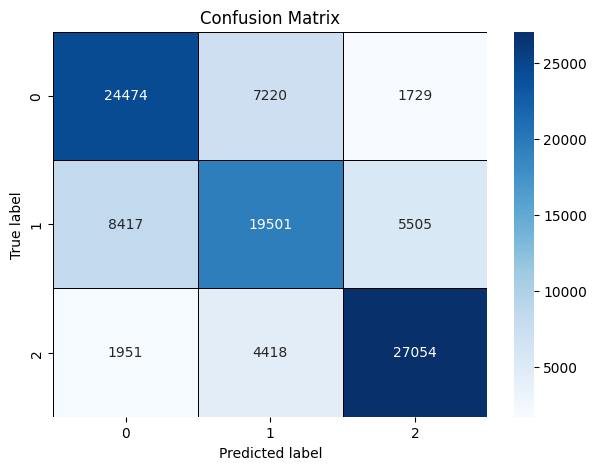

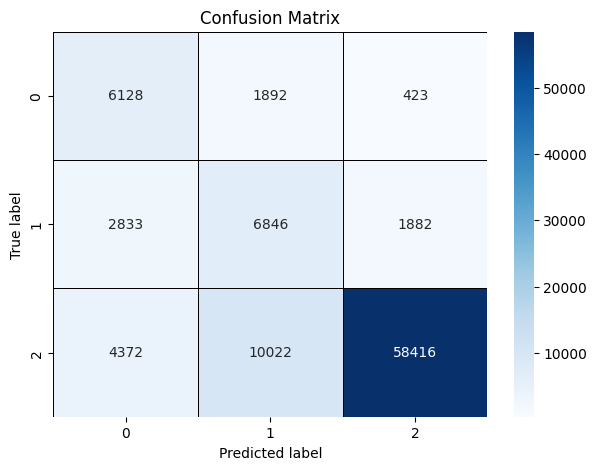

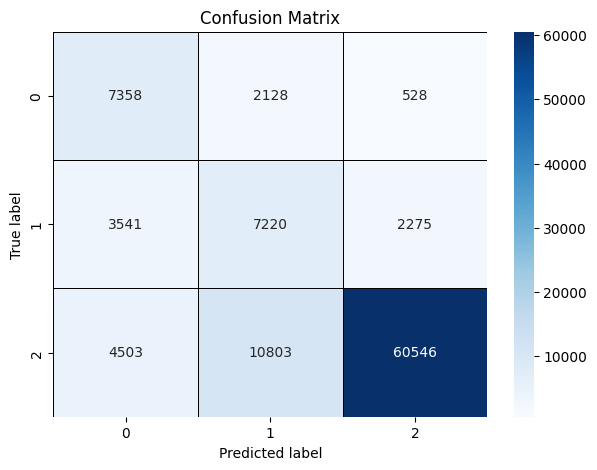

In [14]:
# Get Validation Metrics
print("Train")
train_metrics = get_ml_metrics(lr.transform(df_train))
print("Test")
test_metrics = get_ml_metrics(lr.transform(df_test))
print("OOT")
oot_metrics = get_ml_metrics(lr.transform(df_oot))

##### 3.1.2.2. Logistic Regression CV

K-fold cross validation performs model selection by splitting the dataset into a set of non-overlapping randomly partitioned folds which are used as separate training and test datasets e.g., with k=3 folds, K-fold cross validation will generate 3 (training, test) dataset pairs, each of which uses 2/3 of the data for training and 1/3 for testing. Each fold is used as the test set exactly once. (https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html)

With a balanced dataset (df_train_idf) I can random sample because i have same class sizes.

In [15]:
lr = LogisticRegression(
    featuresCol="features",
    labelCol="Score",
    maxIter=20,
    regParam=0.1
)

grid = ParamGridBuilder().addGrid(lr.maxIter, [20]).build()

cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=grid,
    evaluator=MulticlassClassificationEvaluator(labelCol="Score", metricName="f1"),
    parallelism=2,
    numFolds=3
)

cv = cv.fit(df_train)

In [16]:
print(f"Avg F1: {cv.avgMetrics[0]:.4f} in 3 times CV on a Train Dataset")

Avg F1: 0.7037 in 3 times CV on a Train Dataset


##### 3.1.2.3. Fit Last Estimator

For the last estimator, I will combine train and test dataset and fit a logistic regression to score OOT.

But i need to undersampling this new dataset again.

In [17]:
df_full = df_train.unionAll(df_test)
minority_class_sample = df_full.groupBy("Score").count().orderBy("count").limit(1).select("count").collect()[0][0]

In [18]:
df_sample = undersampling_dataframe(df=df_full, minority_class_sample=minority_class_sample)

+-----+-----+
|Score|count|
+-----+-----+
|    0|41866|
|    1|41866|
|    2|41866|
+-----+-----+



In [19]:
lr = LogisticRegression(
    featuresCol="features",
    labelCol="Score",
    maxIter=20,
    regParam=0.1
)

lr = lr.fit(df_sample)

Full


/home/grc/arep/sentiment-analysis/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/home/grc/arep/sentiment-analysis/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.7075
W. Recall: 0.7075
W. Precision: 0.7050

Label: 0, Recall: 0.7021
Label: 0, Precision: 0.7321

Label: 1, Recall: 0.6253
Label: 1, Precision: 0.5829

Label: 2, Recall: 0.7876
Label: 2, Precision: 0.8073

Mean Recalls: 0.7075, Mean Precisions: 0.7050


OOT


Accuracy: 0.7603
W. Recall: 0.7603
W. Precision: 0.8288

Label: 0, Recall: 0.4763
Label: 0, Precision: 0.7379

Label: 1, Recall: 0.3601
Label: 1, Precision: 0.5522

Label: 2, Recall: 0.9559
Label: 2, Precision: 0.7990

Mean Recalls: 0.6964, Mean Precisions: 0.5975




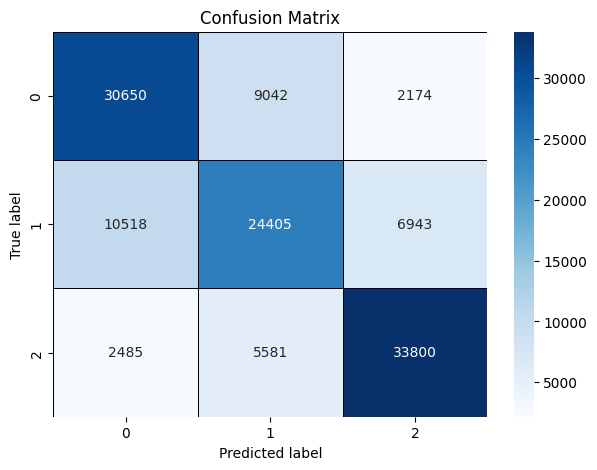

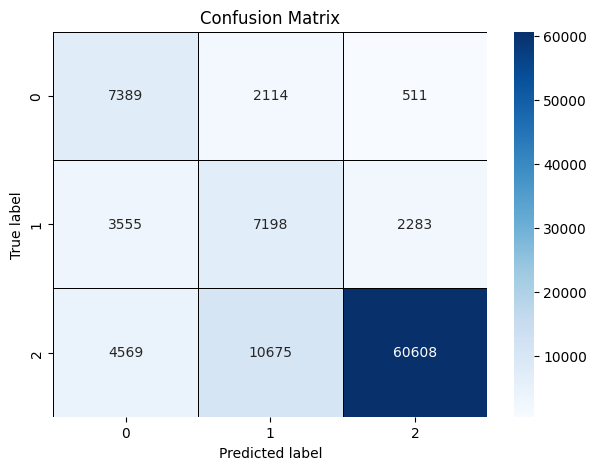

In [22]:
print("Full")
train_metrics = get_ml_metrics(lr.transform(df_sample))
print("OOT")
oot_metrics = get_ml_metrics(lr.transform(df_oot))

In [20]:
lr.write().save("../src/features/logistic_regression_hugging.spark")

## 4.0. Final Estimator Pipeline

In [6]:
artifacts_path = "../src/features"

df_raw = spark.read.format("csv") \
              .option("header", "true") \
              .option("inferSchema", "true") \
              .option("delimiter", ",") \
              .load("../data/Reviews.csv")

df_raw = df_raw.withColumn(
    "Time",
    pf.to_timestamp(pf.from_unixtime("Time"))
)

df_oot = df_raw.filter(
    (pf.year("Time") == 2012) &
    (pf.month("Time") >= 10)
)

### 4.1. Pyspark Pipeline

In [7]:
estimator = LogisticRegressionModel.load(artifacts_path + "/logistic_regression_hugging.spark")

In [8]:
noise_score_removal = NoiseLableRemoval(
    inputCol="Text",
    outputCol="Text",
    labelCol="Score"
)

filter_rows_features = FilterRowsFeatures(
    aggCols=['ProductId', 'UserId', 'Score', 'ProfileName', 'Summary', 'Text'],
    keyCol="Id"
)

clean_corpus = CleanCorpus(
    cleanCols=['ProfileName', 'Text', 'Summary']
)

feature_engineering = FeatureEngineering()

text_embedding = TextEmbeddings()

In [15]:
# Pipeline Fit & Transform
stages = [
    noise_score_removal,
    filter_rows_features,
    clean_corpus,
    feature_engineering,
    text_embedding,
    estimator
]

pipeline = Pipeline(stages=stages)

pipeline = pipeline.fit(df_oot)

df = pipeline.transform(df_oot)

In [16]:
df_oot_with_probas = df_oot.join(
    df.select(
        pf.col("Id"),
        pf.col("probability"),
        pf.col("prediction")
    ),
    on="Id",
    how="inner"
)

In [17]:
df_oot_with_probas.select(
    pf.col('Id'),
    pf.col('ProductId'),
    pf.col('UserId'),
    pf.col('ProfileName'),
    pf.col('Time'),
    pf.col('Summary'),
    pf.col('probability'),
    pf.col('prediction'),
    pf.col('Score')
).show(truncate=False)

+---+----------+--------------+-----------------------------------+-------------------+----------------------------------+--------------------------------------------------------------+----------+-----+
|Id |ProductId |UserId        |ProfileName                        |Time               |Summary                           |probability                                                   |prediction|Score|
+---+----------+--------------+-----------------------------------+-------------------+----------------------------------+--------------------------------------------------------------+----------+-----+
|5  |B006K2ZZ7K|A1UQRSCLF8GW1T|"Michael D. Bigham ""M. Wassir"""  |2012-10-20 21:00:00|Great taffy                       |[0.017060133070951188,0.10197966604242864,0.8809602008866201] |2.0       |5    |
|10 |B00171APVA|A21BT40VZCCYT4|Carol A. Reed                      |2012-10-25 22:00:00|Healthy Dog Food                  |[0.01391492810906535,0.11643467497187467,0.86965039691906]    |2.0